In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

Merging two datasets into one master dataset. 

In [47]:
df1 = pd.read_csv('train_data.csv') 
df2 = pd.read_csv('test_data.csv')
df = pd.concat([df1, df2])

#entire cell is my contribution

In [48]:
df.head(10)
#entire cell is my contribution

,Unnamed: 0,Sentence_id,New_Sentence,Type
0,0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,3,GERSKL27235,"Previous business experience, including but no...",Skill
4,4,HONSSK18415,Delivering fast and right the first time.,SoftSkill
5,5,INDRES9494,Track department expenses and capital budget .,Responsibility
6,6,HONRES51852,Meet performance metrics.,Responsibility
7,7,UAEREQ34683,YOU MUST HAVEBachelors degree in Engineering.,Requirement
8,8,UAEREQ4612,After COVID-19: Ability to travel to manufactu...,Requirement
9,9,INDEDU42721,Six Sigma qualification to at least Green Bel...,Education


In [49]:
df.describe()
#entire cell is my contribution

,Unnamed: 0
count,75144.000000
mean,25548.340001
std,18055.461497
min,0.000000
25%,9392.750000
50%,22542.500000
75%,41328.250000
max,60114.000000


Before dropping the tuples with missing values

In [50]:
df.isna().sum()

Unnamed: 0          0
Sentence_id         0
New_Sentence     1394
Type            15029
dtype: int64

In [51]:
df = df.dropna( how='any',subset=['Type','New_Sentence'])
#entire cell is my contribution

After dropping the tuples with missing values

In [52]:
df.isna().sum()

Unnamed: 0      0
Sentence_id     0
New_Sentence    0
Type            0
dtype: int64

Number of tuples per each type

Text(0, 0.5, 'Count')

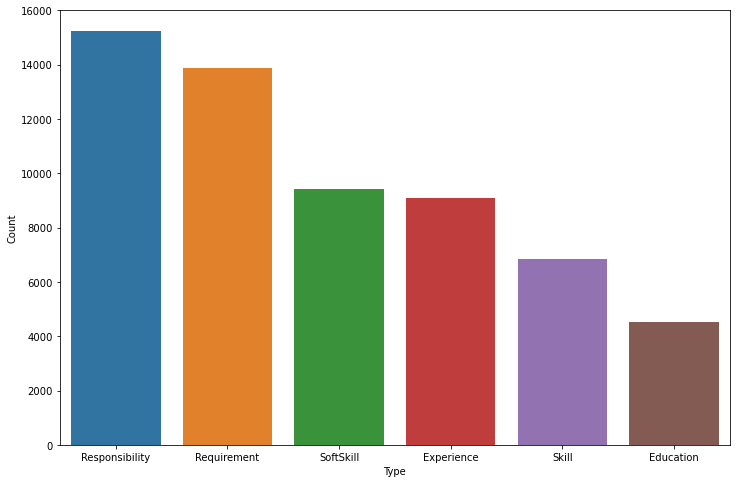

In [54]:
plt.figure(figsize=(12,8))
count = df.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Type')
plt.ylabel('Count')

Splitting data into train validation test.

In [55]:
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [56]:
print("The length of train data is : ",len(train), "\nThe length of validate data is :",len(validate),"\nThe length of test data is : ",len(test))

The length of train data is :  35401 
The length of validate data is : 11800 
The length of test data is :  11801


In [57]:
train.describe()
#entire cell is my contribution

,Unnamed: 0
count,35401.000000
mean,30140.090704
std,17373.025462
min,0.000000
25%,15112.000000
50%,30187.000000
75%,45197.000000
max,60113.000000


In [58]:
train['Type'].value_counts()

Responsibility    9162
Requirement       8318
SoftSkill         5602
Experience        5538
Skill             4106
Education         2675
Name: Type, dtype: int64

Text(0, 0.5, 'Count')

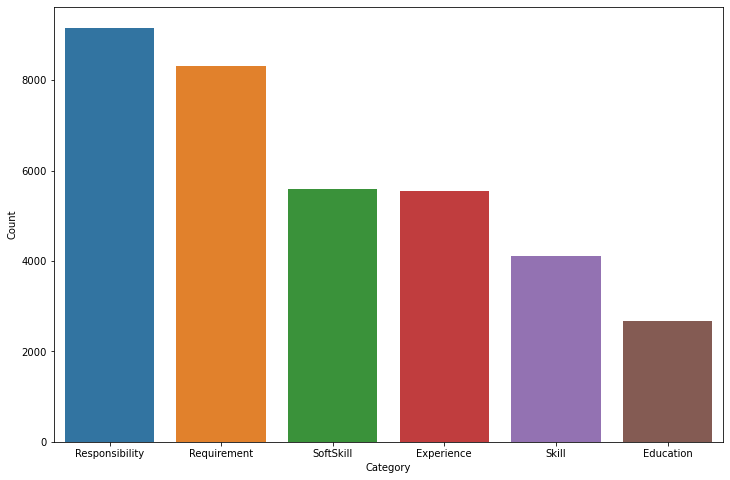

In [59]:
plt.figure(figsize=(12,8))
count = train.Type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Category')
plt.ylabel('Count')

Getting a list of stopwords from nltk library

In [60]:
sw_nltk = stopwords.words('english')
print(sw_nltk)
#entire cell is my contribution using the help of the below mentioned reference.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

REF https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

Counting the number of times, each word has appeared throughout the dataset by creating a dictionary for frequency count of words in the dataset.

In [64]:
def word_counts(data_set) -> list:
    words_in_tuple = dict()
    text = data_set['New_Sentence']
    text = text.to_string()
    text = text.strip()
    text = text.lower()
    
    words = [word for word in text.split(' ') if word not in sw_nltk]
    
    for word in words:
        if word == ' ' or word.isnumeric() == True or len(word) == 0:
            continue
        if word in words_in_tuple:
              words_in_tuple[word] = words_in_tuple[word] + 1
        else:
              words_in_tuple[word] = 1  
    for key in list(words_in_tuple.keys()):  ## creates a list of all keys
      if words_in_tuple[key] < 5:
        del words_in_tuple[key] 
       
    return (words_in_tuple)
vocab = word_counts(train)
print(vocab)
# I have modified the existing code as per my need to get the required results. 

{'five': 59, 'years': 4285, 'mechanical': 162, 'experience': 6561, 'installing': 12, 'operational': 44, 'maintenance': 61, 'good': 838, 'interpersonal,': 29, 'verbal': 202, 'written': 366, 'bachelors': 970, 'degree': 1767, 'business,': 114, 'engineering': 707, 'ability': 2353, 'work': 1438, 'independently': 101, '&': 672, 'manage': 418, 'business': 793, 'marketing': 106, 'leaders': 46, 'working': 962, 'applying': 19, 'design': 473, 'team': 775, 'player': 61, 'willing': 66, 'stand': 9, 'collaborating': 21, 'development': 566, 'teams': 182, 'launch': 11, 'new': 241, 'ensuring': 49, 'dummy': 506, 'block': 506, 'text': 506, 'iso': 16, 'and/or': 184, 'support': 596, 'des': 100, 'basic': 166, 'knowledge': 1527, 'operating': 71, 'microsoft': 169, 'focus': 60, 'architecting': 20, 'systems,': 37, 'including': 151, 'minimum': 885, 'high': 267, 'level': 219, 'distribution': 17, '7+': 113, 'teamcenter': 18, 'plm': 9, 'large': 96, 'visual': 18, 'equivalent': 101, 'required,': 22, 'chemical': 91, '5

Conditional count of the words for every label 

Refrenece blog : https://taherparatha.wordpress.com/portfolio/classifying-news-articles-using-naive-bayes-classifier-from-scratch/

In [65]:
import re
Types = df['Type'].unique()
def conditional_count_values(dataset,label):  
  word_count = {}
  for typ in Types:
    word_dict = {}
    data = df[df[label] == typ]['New_Sentence']
    for row in data:
      words = list(set(re.split("[^a-zA-Z]",str(row))))
      for word in words:
        word = word.lower()
        if word in word_dict:
          word_dict[word] = word_dict[word]+1
        else:
          word_dict[word] = 1
    for word, count in dict(word_dict).items():
      if (len(word)<3) or (count<=5):
        word_dict.pop(word)
    word_count[typ] = word_dict
  
  return pd.DataFrame(word_count).fillna(0)

print(conditional_count_values(train,"Type"))

           Responsibility  Requirement  Skill  SoftSkill  Education  \
review              336.0         18.0    8.0       10.0        0.0   
documents           126.0         20.0    6.0        0.0        0.0   
design              924.0        404.0  315.0      158.0       93.0   
systems             540.0        554.0  306.0       58.0      210.0   
technical           903.0        515.0  221.0      254.0      305.0   
...                   ...          ...    ...        ...        ...   
jaar                  0.0          0.0    0.0        0.0        0.0   
heavy                 0.0          0.0    0.0        0.0        0.0   
ado                   0.0          0.0    0.0        0.0        0.0   
poste                 0.0          0.0    0.0        0.0        0.0   
semi                  0.0          0.0    0.0        0.0        0.0   

           Experience  
review            6.0  
documents         0.0  
design          479.0  
systems         425.0  
technical       443.0  
...

Function to returns the probability of the word with total number of docs.

In [66]:
def probability_of_word_in_all_documents(dataset,word_given,smoothing):
  return((word_counts(dataset)[word_given] + smoothing )/(len(dataset) + (len(dataset['Type'].unique()) * smoothing)))

Conditional probability value

In [67]:
def conditional_probability(dataset,word,category,smoothing):
  conditional_value_dataframe = conditional_count_values(train,'Type')
  probability_value = (conditional_value_dataframe.loc[word,category])*smoothing / ((conditional_value_dataframe[category].sum()) + (smoothing * len(conditional_value_dataframe[category])))
  return probability_value

Probability of every class label

In [68]:
def count_probability_class(category_set):
  result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
  return(result_probabilty)

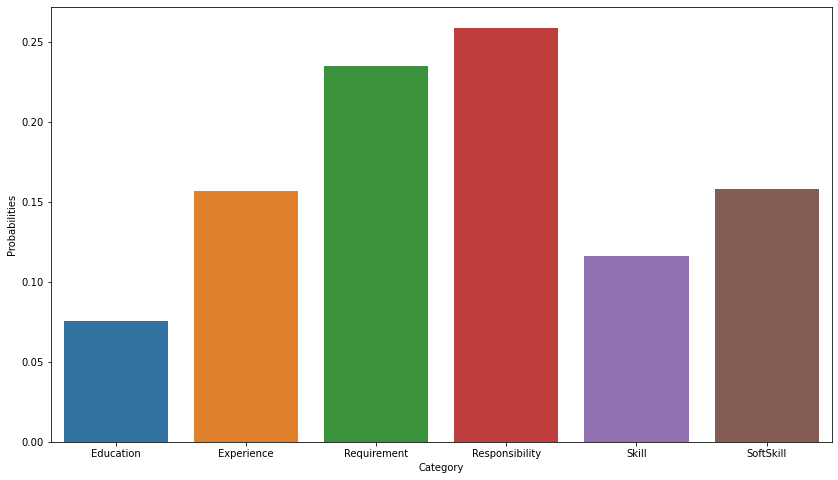

In [69]:
result_probabilty = train.groupby('Type').size().div(len(train)) #count()['category']/len(category)
plt.figure(figsize=(14,8))
sns.barplot(x=result_probabilty.index, y=result_probabilty)
plt.xlabel('Category')
plt.ylabel('Probabilities')
plt.show()

Function to calculate the Naive Bayes probability.

In [21]:
def nb_probability(word,data,category,smoothing):
  final_prob = conditional_probability(data,word,category,smoothing) * count_probability_class(train)
  print(final_prob[category])
  return final_prob[category]

# TRAINING THE DATASET.

In [70]:
vocab_train = word_counts(train)
cond_words_train = conditional_count_values(train,'Type')
cond_words_train.dropna()

,Responsibility,Requirement,Skill,SoftSkill,Education,Experience
review,336.0,18.0,8.0,10.0,0.0,6.0
documents,126.0,20.0,6.0,0.0,0.0,0.0
design,924.0,404.0,315.0,158.0,93.0,479.0
systems,540.0,554.0,306.0,58.0,210.0,425.0
technical,903.0,515.0,221.0,254.0,305.0,443.0
...,...,...,...,...,...,...
jaar,0.0,0.0,0.0,0.0,0.0,6.0
heavy,0.0,0.0,0.0,0.0,0.0,7.0
ado,0.0,0.0,0.0,0.0,0.0,6.0
poste,0.0,0.0,0.0,0.0,0.0,6.0


Finding the probability of the word “teams“.

In [23]:
probability_of_word_in_all_documents(train,"teams",1)  

0.00539441353404694

Calculating the Naive Bayes probability of the word “teams” across every category



In [24]:
class_train_probability = count_probability_class(train)
for i in train['Type'].unique():
  print(nb_probability("teams",train,i,0.1))

9.344851661833277e-05
9.344851661833277e-05
2.801254956607816e-05
2.801254956607816e-05
6.391339453349277e-05
6.391339453349277e-05
6.807750974673483e-05
6.807750974673483e-05
4.240273507013381e-06
4.240273507013381e-06
1.349620171532188e-05
1.349620171532188e-05


# TESTING THE DATASET.

In [71]:
vocab_test = word_counts(test)
cond_words_test = conditional_count_values(test,'Type')
cond_words_test.dropna()

,Responsibility,Requirement,Skill,SoftSkill,Education,Experience
review,336.0,18.0,8.0,10.0,0.0,6.0
documents,126.0,20.0,6.0,0.0,0.0,0.0
design,924.0,404.0,315.0,158.0,93.0,479.0
systems,540.0,554.0,306.0,58.0,210.0,425.0
technical,903.0,515.0,221.0,254.0,305.0,443.0
...,...,...,...,...,...,...
jaar,0.0,0.0,0.0,0.0,0.0,6.0
heavy,0.0,0.0,0.0,0.0,0.0,7.0
ado,0.0,0.0,0.0,0.0,0.0,6.0
poste,0.0,0.0,0.0,0.0,0.0,6.0


In [26]:
class_test_probability = count_probability_class(test)
class_test_probability

Type
Education         0.077512
Experience        0.155278
Requirement       0.233044
Responsibility    0.258241
Skill             0.116889
SoftSkill         0.159035
dtype: float64

In [27]:
for i in test['Type'].unique():
  print(nb_probability("teams",test,i,0.1)) 

9.344851661833277e-05
9.344851661833277e-05
6.807750974673483e-05
6.807750974673483e-05
2.801254956607816e-05
2.801254956607816e-05
6.391339453349277e-05
6.391339453349277e-05
1.349620171532188e-05
1.349620171532188e-05
4.240273507013381e-06
4.240273507013381e-06
